# 简介

本项目来源于共创计划开发性课题CAE领域的基于飞桨+DeepXDE/PaddleScience的复杂结构受力分析。深度学习擅长数据驱动，而工程结构有各种控制方程，PINN（Physics-informed Neural Network）方法利用控制方程加速深度学习神经网络收敛，甚至在无训练数据的情况下实现无监督学习。

板是工程结构中常见构件，板控制方程存在高阶微分，这个问题的解决可以为后续解决复杂结构问题打下良好基础。从标准教科书中可以获得薄板小挠度理论的基本方程以及相关的边界条件表达式，教科书可参考《钱伟长，叶开沅，弹性力学，科学出版社，1956》。

薄板小挠度理论的基本方程为：
$$
\frac{\partial^4 w}{\partial x^4}+2 \frac{\partial^4 w}{\partial x^2 \partial y^2}+\frac{\partial^4 w}{\partial y^4}=\frac{q}{D}
$$

其中 $w(x,y)$ 表示薄板的挠度，即薄板在垂直载荷作用下的变形或偏移量，$x,y$ 表示薄板在平面内的坐标，$D$ 为薄板的弯曲刚度，$q$ 是作用在薄板上的面载荷，表示每单位面积上的外部载荷。

在本问题中，矩形薄板 $x$ 方向长 $2m$，$y$ 方向宽 $1m$，板厚 $10mm$，$x$ 方向左右两边处于简支状态（可以转动但不能位移），$y$ 方向上下两边自由（没有任何约束，可以自由移动和转动）。



左右两边 $(x=-1 \mid x=+1)$ 为简支边界条件，因此挠度 $w$ 和弯矩 $M_x$ 都为 $0$ :

$$
(w)_{x=-1 \mid x=+1}=0, \quad\left(M_x\right)_{x=-1 \mid x=+1}=0
$$


由于 $M_x=-D\left(\frac{\partial^2 w}{\partial x^2}+\mu \frac{\partial^2 w}{\partial y^2}\right)$， 且 $\frac{\partial^2 w}{\partial y^2}=0$， 所以简支边界条件可化简为：

$$
(w)_{x=-1 \mid x=+1}=0, \quad\left(\frac{\partial^2 w}{\partial x^2}\right)_{x=-1 \mid x=+1}=0
$$


上下两边 $(y=-0.5 \mid y=+0.5)$ 为自由边界条件， 弯矩、扭矩、横向剪切力都为 $0$ :

$$
\left(M_y\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0, \quad\left(M_{x y}\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0, \quad\left(Q_y\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0
$$


由于 $M_y=-D\left(\frac{\partial^2 w}{\partial y^2}+\mu \frac{\partial^2 w}{\partial x^2}\right), \quad M_{x y}=-D(1-\mu) \frac{\partial^2 w}{\partial x \partial y}, \quad Q_y=-D \frac{\partial}{\partial y}\left(\frac{\partial^2 w}{\partial x^2}+\frac{\partial^2 w}{\partial y^2}\right)$ ，且扭矩可以变换为等效剪力， 扭矩和横向剪力合并为 $\left(Q_y+\frac{\partial M_{x y}}{\partial x}\right)_{\mathrm{y}=-0.5 \mid \mathrm{y}=+0.5}=0$， 所以自由边界条件用挠度表示为

$$
\left(\frac{\partial^2 w}{\partial y^2}+\mu \frac{\partial^2 w}{\partial x^2}\right)_{y=-0.5 \mid y=+0.5}=0, \quad\left(\frac{\partial^3 w}{\partial y^3}+(2-\mu) \frac{\partial^3 w}{\partial x^2 \partial y}\right)_{y=-0.5 \mid y=+0.5}=0
$$


## 1. 设置计算域

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import ppsci
import sympy as sp
import numpy as np

# 设置薄板计算域长、宽参数
Lx = 2.0 # 薄板x方向长度(m)
Ly = 1.0 # 薄板y方向宽度(m)

# 设置方程参数
E = 210000.0e6 # 弹性模量(Pa)
mu = 0.28 # 薄板泊松比(无量纲)
h = 0.01 # 薄板厚度(m)
D = E * (h**3) / (12 * (1 - mu**2)) # 薄板弯曲刚度(kN*m^2)
q = 1000.0 # 均布载荷(N/m^2)

rectangle = ppsci.geometry.Rectangle([-Lx / 2, -Ly / 2], [Lx / 2, Ly / 2]) # 创建薄板几何形状

## 2. 编写方程中的表达式

In [2]:
# 使用sympy库计算符号公式
x, y = sp.symbols("x y") # 定义符号变量x, y
w = sp.Function("w")(x, y) # 定义函数 w(x,y)
left = w.diff(x, 4) + 2 * w.diff(x, 2).diff(y, 2) + w.diff(y, 4) # 定义薄板弯曲的双调和方程的左侧部分
right = q / D # 方程右侧的载荷项，表示均布载荷 q 除以板的弯曲刚度 D。这是薄板在载荷下的响应。
res = left - right # 定义方程残差
res # 可视化显示方程残差

Derivative(w(x, y), (x, 4)) + Derivative(w(x, y), (y, 4)) + 2*Derivative(w(x, y), (x, 2), (y, 2)) - 0.0526628571428571

## 3. 初始化神经网络模型

In [3]:
model = ppsci.arch.MLP(["x", "y"], ["w"], 4, 50)
model # 可视化显示模型结构

W1117 17:10:41.976225  7764 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W1117 17:10:41.977502  7764 gpu_resources.cc:164] device: 0, cuDNN Version: 8.7.


MLP(
  (linears): LayerList(
    (0): Linear(in_features=2, out_features=50, dtype=float32)
    (1): Linear(in_features=50, out_features=50, dtype=float32)
    (2): Linear(in_features=50, out_features=50, dtype=float32)
    (3): Linear(in_features=50, out_features=50, dtype=float32)
  )
  (acts): LayerList(
    (0): Tanh()
    (1): Tanh()
    (2): Tanh()
    (3): Tanh()
  )
  (last_fc): Linear(in_features=50, out_features=1, dtype=float32)
)

## 4. 初始化控制方程和边界条件

接下来讲解如何将开头简介中的控制方程和边界条件转换为深度学习代码。

### 4.1 控制方程

控制方程表示在矩形薄板区域内部，挠度和弯矩所满足的微分方程。因此可以在矩形内部采样足够多的配点(collation points)用于模型训练，如下所示：

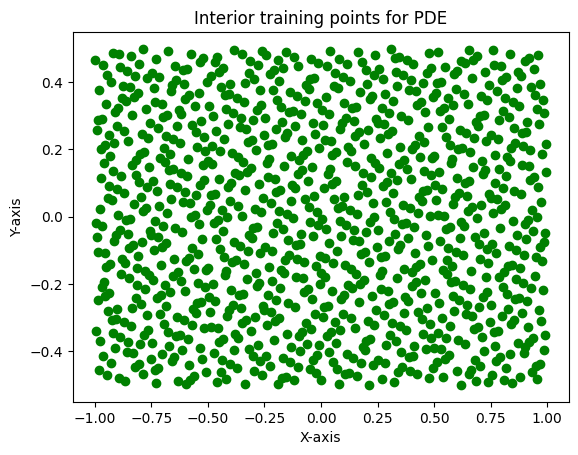

In [4]:
interior_points = rectangle.sample_interior(1000, random='Halton')
px1, py1 = interior_points["x"], interior_points["y"]
plt.scatter(px1, py1, color='green')
plt.title('Interior training points for PDE')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

接下来将控制方程转为实际深度学习模型中需要的约束条件：内部约束
> $$
\frac{\partial^4 w}{\partial x^4}+2 \frac{\partial^4 w}{\partial x^2 \partial y^2}+\frac{\partial^4 w}{\partial y^4}=\frac{q}{D}
$$

In [5]:
pde_contraint = ppsci.constraint.InteriorConstraint(
    {"kirchhoff_res": res}, # 残差表达式
    {"kirchhoff_res": 0.0}, # 残差目标优化值
    rectangle, # 约束区域：薄板矩形
    {
        "dataset": "IterableNamedArrayDataset",
        "iters_per_epoch": 1,
        "batch_size": 20000, # 采样两万个配点用于训练
    },
    random="Halton",
    loss=ppsci.loss.MSELoss(), # 使用均方根误差损失函数
)

[2024/11/17 17:10:44] ppsci WARNING: Logger has already been automatically initialized as `log_file` is set to None by default, information will only be printed to terminal without writting to any file.


### 4.2 简支边界条件

接下来讲解如何将开头简介中的左右简支边界条件转换为深度学习代码。

同样先预览一下简支边界条件所对应的在矩形左右边界上的训练点

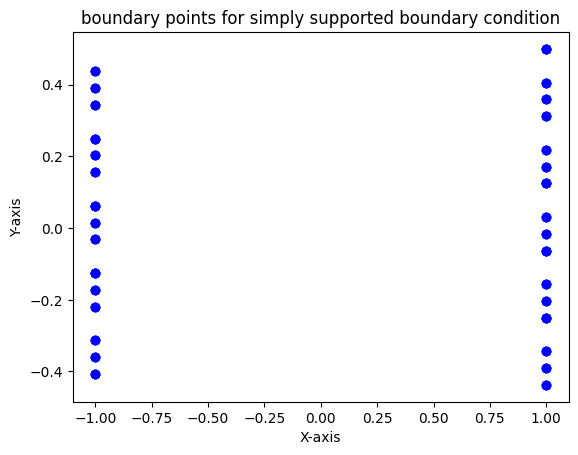

In [6]:
lr_buondary_points = rectangle.sample_boundary(100, random='Halton', criteria=lambda x, y: np.isclose(x, -Lx / 2) | np.isclose(x, Lx / 2))
px2, py2 = lr_buondary_points["x"], lr_buondary_points["y"]
plt.scatter(px2, py2, color='blue')
plt.title('boundary points for simply supported boundary condition')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

接下来将控制方程转为实际深度学习模型中需要的约束条件：(简支)边界约束
> $$
(w)_{x=-1 \mid x=+1}=0, \quad\left(\frac{\partial^2 w}{\partial x^2}\right)_{x=-1 \mid x=+1}=0
$$

In [7]:
constraint_left_right = ppsci.constraint.BoundaryConstraint(
    {"w": w, "ddw_dxx": w.diff(x, 2)}, # 挠度和 x 轴弯矩表达式
    {"w": 0, "ddw_dxx": 0}, # 挠度和 x 轴弯矩目标值均为0
    rectangle,
    {
        "dataset": "IterableNamedArrayDataset",
        "iters_per_epoch": 1,
        "batch_size": 10000, # 采样一万个点用于训练
    },
    criteria=lambda x, y: np.isclose(x, -Lx / 2) | np.isclose(x, Lx / 2), # 采样点在左右两侧边界上
    loss=ppsci.loss.MSELoss(), # 使用均方根误差损失函数
)

### 4.3 自由边界条件

接下来讲解如何将开头简介中的左右简支边界条件转换为深度学习代码。

同样先预览一下简支边界条件所对应的在矩形上下边界上的训练点

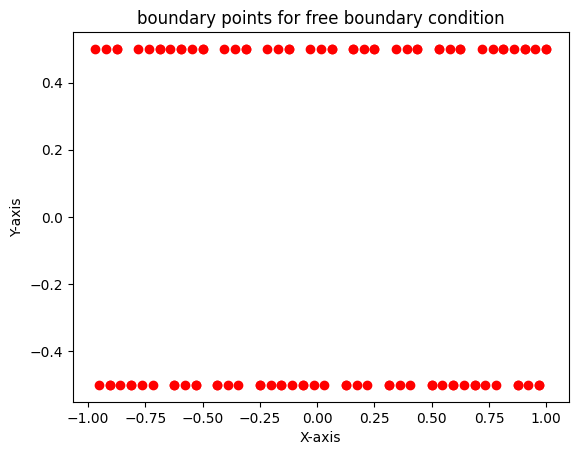

In [8]:
ud_buondary_points = rectangle.sample_boundary(100, random='Halton', criteria=lambda x, y: np.isclose(y, -Ly / 2) | np.isclose(y, Ly / 2))
px3, py3 = ud_buondary_points["x"], ud_buondary_points["y"]
plt.scatter(px3, py3, color='red')
plt.title('boundary points for free boundary condition')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

接下来将自由边界条件转为实际深度学习模型中需要的约束条件：(自由)边界约束
> $$
\left(\frac{\partial^2 w}{\partial y^2}+\mu \frac{\partial^2 w}{\partial x^2}\right)_{y=-0.5 \mid y=+0.5}=0, \quad\left(\frac{\partial^3 w}{\partial y^3}+(2-\mu) \frac{\partial^3 w}{\partial x^2 \partial y}\right)_{y=-0.5 \mid y=+0.5}=0
$$

In [9]:
constraint_up_down = ppsci.constraint.BoundaryConstraint(
    {
        "item1": w.diff(y, 2) + mu * w.diff(x, 2), # 上下边界上需要满足的条件
        "item2": w.diff(y, 3) + (2 - mu) * w.diff(x, 2).diff(y), # 上下边界上需要满足的条件
    },
    {"item1": 0.0, "item2": 0.0}, # 上下边界上需要满足的条件
    rectangle,
    {
        "dataset": "IterableNamedArrayDataset",
        "iters_per_epoch": 1,
        "batch_size": 10000, # 采样一万个点用于训练
    },
    criteria=lambda x, y: np.isclose(y, -Ly / 2) | np.isclose(y, Ly / 2), # 采样点在左右两侧边界上
    loss=ppsci.loss.MSELoss(), # 使用均方根误差损失函数
)

综上所述，控制方程、简支边界条件、自由边界条件所用的训练数据点预览如下：

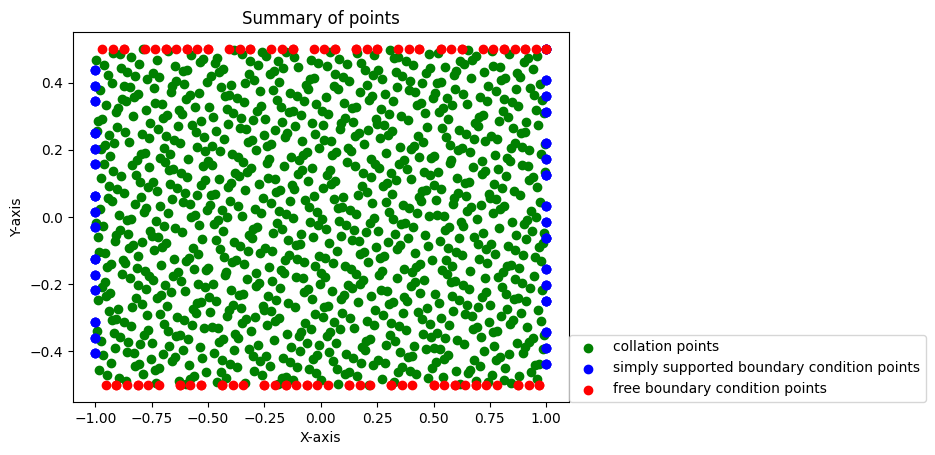

In [10]:
plt.scatter(px1, py1, color='green', label='collation points')
plt.scatter(px2, py2, color='blue', label='simply supported boundary condition points')
plt.scatter(px3, py3, color='red', label='free boundary condition points')
plt.title('Summary of points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0)
plt.show()

## 5. 初始化深度学习求解器并开始求解

In [11]:
# set optimizer
opt = ppsci.optimizer.LBFGS(max_iter=1000)(model)
solver = ppsci.solver.Solver(
    model,
    {
        "pde_contraint": pde_contraint,
        "constraint_left_right": constraint_left_right,
        "constraint_up_down": constraint_up_down,
    },
    output_dir="./output_kirchhoff",
    optimizer=opt,
    epochs=400,
    iters_per_epoch=1,
    log_freq=100,
    # pretrained_model_path="./output_kirchhoff/checkpoints/latest"
)
solver.train()

[2024/11/17 17:10:45] ppsci INFO: Using paddlepaddle 3.0.0 on device Place(gpu:0)
[2024/11/17 17:10:45] ppsci MESSAGE: Set to_static=False for computational optimization.
[2024/11/17 17:11:51] ppsci INFO: [Train][Epoch   1/400][Iter 1/1] lr: 1.00000, loss: 0.00000, pde_contraint: 0.00000, constraint_left_right: 0.00000, constraint_up_down: 0.00000, batch_cost: 66.07724s, reader_cost: 0.00001s, ips: 605.35, eta: 7:19:24
[2024/11/17 17:11:51] ppsci MESSAGE: Finish saving checkpoint to: ./output_kirchhoff/checkpoints/latest(latest checkpoint will be saved every epoch as expected, but this log will be printed only once for tidy logging)
[2024/11/17 17:12:13] ppsci INFO: [Train][Epoch 100/400][Iter 1/1] lr: 1.00000, loss: 0.00000, pde_contraint: 0.00000, constraint_left_right: 0.00000, constraint_up_down: 0.00000, batch_cost: 0.16517s, reader_cost: 0.00002s, ips: 242176.51, eta: 0:00:49
[2024/11/17 17:12:32] ppsci INFO: [Train][Epoch 200/400][Iter 1/1] lr: 1.00000, loss: 0.00000, pde_contra

## 6. 结果可视化

num_cords = 10201
(10201,) (10201,) (10201, 1)


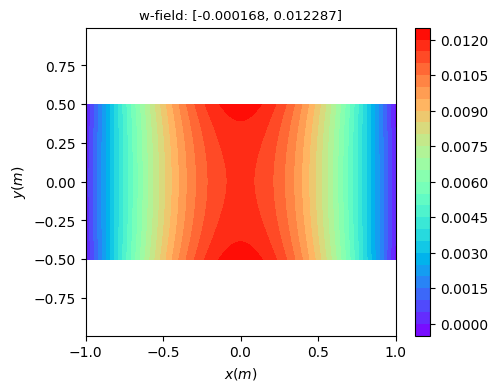

In [12]:
# plot result
num_cord0 = 101
num_cord1 = 101
num_cords = num_cord0 * num_cord1
print(f"num_cords = {num_cords}")
x, y = np.meshgrid(
    np.linspace(
        start=-Lx / 2, stop=Lx / 2, num=num_cord0, endpoint=True, dtype="float32"
    ),
    np.linspace(
        start=-Ly / 2, stop=Ly / 2, num=num_cord1, endpoint=True, dtype="float32"
    ),
)
x = x.ravel()
y = y.ravel()
# predict solution of w(x, y) on the 2D grid
w_pred = solver.predict({"x": x[:, None], "y": y[:, None]}, return_numpy=True)["w"]
fig = plt.figure(100, figsize=(5, 4))
y_min = w_pred.min(axis=(0,))[0]
y_max = w_pred.max(axis=(0,))[0]
ax1 = plt.subplot(1, 1, 1)
plt.tricontourf(x, y, w_pred[:, 0], levels=30, cmap="rainbow")
print(x.shape, y.shape, w_pred.shape)
cb1 = plt.colorbar()
plt.axis("equal")
plt.xlabel("$x (m)$")
plt.ylabel("$y (m)$")
plt.title(f"w-field: [{y_min:.6f}, {y_max:.6f}]", fontsize=9.5)
plt.show()
# plt.savefig("./result.jpg")
# print("saved matplotlib to: ./result.jpg")

## 7.有限元计算结果比较

通过比较，可以发现PINN方法计算结果和有限元方法计算结果基本一致。这里有限元计算所用薄板的几何参数、材料参数、载荷及边界条件和第2部分所描述薄板是一样的，有限元计算所用软件为SIPESC2022。PINN方法计算的最大挠度是12.2mm，有限元方法计算的最大挠度是12.2mm，两者的计算结果相差很小。
<img src="./FEM.png" alt="FEM_result" width="60%">
